In [2]:
import numpy as np
from scipy.stats.mstats import mode
from copy import deepcopy
import pandas as pd
import time
%matplotlib inline
from helper import *

In [3]:
df_train = load_train_data()

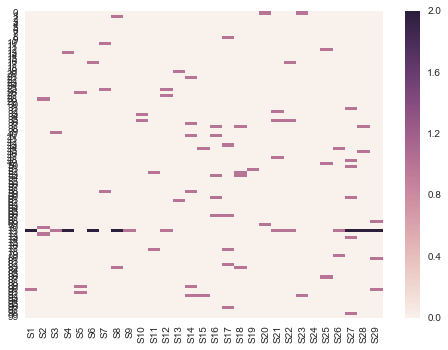

In [5]:
import seaborn as sns
df = df_train[['S'+str(i) for i in xrange(1, 30)]][:100]

_ = sns.heatmap(df)

In [74]:
# Nearest neighbors model
adjacency_list = {
    1: [2, 4, 35],
    2: [1, 34, 35, 36, 41],
    3: [4, 8],
    4: [1, 3],
    5: [7, 45],
    6: [8, 12],
    7: [5, 55],
    8: [3, 6],
    9: [12, 44],
    10: [11, 55],
    11: [10, 13],
    12: [6, 9],
    13: [11, 39],
    14: [16, 54],
    15: [14, 16],
    16: [14, 15, 17],
    17: [16, 56],
    18: [19, 56],
    19: [18, 20],
    20: [19, 21],
    21: [20, 22, 23],
    22: [21, 23, 43],
    23: [21, 24],
    24: [23, 25],
    25: [24, 26],
    26: [25, 27],
    27: [26, 28, 29],
    28: [27, 47],
    29: [27, 30],
    30: [29, 31],
    31: [30, 32],
    32: [31, 33],
    33: [32, 34, 35],
    34: [2, 33, 35, 36, 41],
    35: [1, 2, 34, 36, 41],
    36: [2, 34, 35, 41],
    37: [36, 38],
    38: [37, 40],
    39: [13, 43],
    40: [38],
    41: [2, 36, 42],
    42: [41, 46],
    43: [22, 39],
    44: [9, 45],
    45: [5, 44],
    46: [42],
    47: [28, 48],
    48: [47, 49],
    49: [48, 50],
    50: [49, 51],
    51: [50, 52, 53],
    52: [50, 51, 53],
    53: [51, 52, 54],
    54: [53, 14],
    55: [7, 10],
    56: [17, 18]
}

In [78]:

threshold = 12 # will produce the same like above

threshold = 20 # a bigger list

def compute_adjlist(threshold):
    # computing the adjacency list based on distance
    for key in xrange(56):
        node = key + 1
        adjacency_list[node] = []
        # go through all other nodes, if distance is below threshold, fine!
        for other_key in xrange(56):
            if other_key == key:
                continue

            a = np.array([df_sensors.loc[key].X, df_sensors.loc[key].Y])
            b = np.array([df_sensors.loc[other_key].X, df_sensors.loc[other_key].Y])
            dist = np.linalg.norm(a - b, ord=1)

            if dist < threshold:
                adjacency_list[node].append(other_key + 1)
                
    return adjacency_list
    
adjacency_list = compute_adjlist(20.) # best model
adjacency_list = compute_adjlist(27.) 
print adjacency_list

{1: [2, 3, 4, 8, 33, 34, 35, 36, 41, 42], 2: [1, 3, 4, 34, 35, 36, 37, 41, 42, 46], 3: [1, 2, 4, 6, 8, 12, 35], 4: [1, 2, 3, 6, 8, 35, 41], 5: [7, 9, 10, 44, 45, 55], 6: [3, 4, 8, 9, 12, 44], 7: [5, 10, 11, 44, 45, 55], 8: [1, 3, 4, 6, 9, 12], 9: [5, 6, 8, 12, 44, 45], 10: [5, 7, 11, 13, 39, 55], 11: [7, 10, 13, 39, 43, 55], 12: [3, 6, 8, 9, 44, 45], 13: [10, 11, 22, 39, 43, 55], 14: [15, 16, 17, 52, 53, 54, 56], 15: [14, 16, 17, 54, 56], 16: [14, 15, 17, 18, 53, 54, 56], 17: [14, 15, 16, 18, 19, 54, 56], 18: [16, 17, 19, 20, 21, 56], 19: [17, 18, 20, 21, 22, 23, 56], 20: [18, 19, 21, 22, 23, 24, 43, 56], 21: [18, 19, 20, 22, 23, 24, 25, 39, 43], 22: [13, 19, 20, 21, 23, 24, 39, 43], 23: [19, 20, 21, 22, 24, 25, 26, 43], 24: [20, 21, 22, 23, 25, 26, 27], 25: [21, 23, 24, 26, 27, 28, 29], 26: [23, 24, 25, 27, 28, 29, 30, 47], 27: [24, 25, 26, 28, 29, 30, 31, 47, 48], 28: [25, 26, 27, 29, 30, 47, 48, 49], 29: [25, 26, 27, 28, 30, 31, 32, 47], 30: [26, 27, 28, 29, 31, 32], 31: [27, 29, 30

In [79]:
# compute weights based on distance
def compute_invdist_weights(adjacency_list):
    df_sensors = pd.read_csv('data/sensor-coordinates.txt')
    df_sensors.columns = ['SID', 'X', 'Y']

    weight_list = {}
    for key in adjacency_list.keys():
        weight_list[key] = []
        b = np.array([df_sensors.loc[key - 1].X, df_sensors.loc[key - 1].Y])
        for el in adjacency_list[key]:
            # manhattan distance
            a = np.array([df_sensors.loc[el - 1].X, df_sensors.loc[el - 1].Y])
            dist = np.linalg.norm(a - b, ord=1)

            # inverse distance weighting
            weight_list[key].append(1.0 / dist)

        # scale it accordingly
        weight_list[key] = np.array(weight_list[key])
        weight_list[key] = weight_list[key] / np.sum(weight_list[key])
    return weight_list

In [80]:
weight_list = compute_invdist_weights(adjacency_list)
print weight_list

{1: array([ 0.17543772,  0.09576491,  0.17543772,  0.06582782,  0.06617797,
        0.07029072,  0.14840706,  0.06839097,  0.0785363 ,  0.05572882]), 2: array([ 0.17496312,  0.07003462,  0.10500255,  0.09562852,  0.11826339,
        0.09213714,  0.06360257,  0.14180344,  0.08145165,  0.05711301]), 3: array([ 0.11561967,  0.08478413,  0.25459191,  0.13312487,  0.25423282,
        0.08737328,  0.07027332]), 4: array([ 0.21652198,  0.12994373,  0.26025453,  0.08935994,  0.13003543,
        0.09922467,  0.07465973]), 5: array([ 0.27133525,  0.09625235,  0.08810761,  0.14214537,  0.27168401,
        0.13047541]), 6: array([ 0.13807213,  0.09066424,  0.28984444,  0.13046034,  0.26368077,
        0.08727809]), 7: array([ 0.27963461,  0.13446627,  0.09084044,  0.09613211,  0.13990711,
        0.25901946]), 8: array([ 0.08276648,  0.26475934,  0.13247309,  0.29103003,  0.09033415,
        0.13863691]), 9: array([ 0.08874403,  0.13599573,  0.09378339,  0.26917387,  0.27486866,
        0.13743433

In [86]:
# Several possibilities to average the result among the neighbors:
#    - cumulative sum of neighbors (v1)
#    - average (truncated) (v2)
#    - average (raw) (v3) 
#    - average (rounded) (v4)
#    - average with inv distance weight, larger adj list (raw) (v5 Leo) ** best (20. euclidean)
def fill_neighbors(row, col_name, adjacency_list):
    if row[col_name] == -1:
        new_value = 0.
        count = 0
        col_ind = int(col_name[1:])
        pos = 0
        for n in adjacency_list[col_ind]:
            if row[n] != -1:
                new_value += row[n] * weight_list[col_ind][pos]
                count += weight_list[col_ind][pos] # + 1
            pos = pos + 1
            
        # if some neighbours were working return their average (raw)
        if count:
            return round(new_value / (1. * count))
        
        # if no neighbours were working, return 0 (most frequent value)
        return new_value
    else:
        return row[col_name]



In [87]:
col_names = ['S'+str(i) for i in xrange(1, 57)]
df_train_neighbors_avg = df_train.copy()

In [88]:
for col_name in col_names:
    start = time.time()
    df_train_neighbors_avg[col_name] = df_train.apply(lambda row: fill_neighbors(row, col_name, adjacency_list),axis=1)
    total_time = time.time() - start
    print 'Col {} computed in {}'.format(col_name, total_time)

Col S1 computed in 1.23386693001
Col S2 computed in 1.05954504013
Col S3 computed in 1.02584791183
Col S4 computed in 1.24851107597
Col S5 computed in 0.884828090668
Col S6 computed in 2.43762898445
Col S7 computed in 0.820897817612
Col S8 computed in 0.950500011444
Col S9 computed in 3.22554683685
Col S10 computed in 0.923029184341
Col S11 computed in 0.835780143738
Col S12 computed in 1.20586013794
Col S13 computed in 3.72276997566
Col S14 computed in 4.17825698853
Col S15 computed in 0.926348924637
Col S16 computed in 0.761439085007
Col S17 computed in 3.11903905869
Col S18 computed in 0.948646068573
Col S19 computed in 0.882948875427
Col S20 computed in 4.58948707581
Col S21 computed in 1.05897092819
Col S22 computed in 0.991276979446
Col S23 computed in 3.93789720535
Col S24 computed in 0.941859006882
Col S25 computed in 0.83300614357
Col S26 computed in 3.2597630024
Col S27 computed in 0.862055778503
Col S28 computed in 3.38520884514
Col S29 computed in 4.66878890991
Col S30 comp

In [89]:
# Checking that all the values are filled (i.e no -1 left)
cum_sum = 0
for col in col_names:
    cum_sum += len(df_train_neighbors_avg[df_train_neighbors_avg[col] == -1])
print cum_sum

0


In [90]:
create_submission_file(df_train_neighbors_avg, 'nearest_v6Leo.csv')